# Imports

In [1]:
import os
import numpy as np
import random
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import cv2
from utils import *

from skimage.feature import hog

/Users/maiyacaldwell/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/maiyacaldwell/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Helper Functions

In [2]:
# define a function to generate a grid of histograms of intensity counts for each channel
# in each image in each class
def generate_hist_channel_grid(files, directory, channels='hsv'):
    if channels == 'rgb':
        ch1 = 'Red'
        ch2 = 'Green'
        ch3 = 'Blue'
        colors = ['r', 'g', 'b']  # Specify colors for RGB channels
    elif channels == 'lab':
        ch1 = 'L*'
        ch2 = 'a*'
        ch3 = 'b*'
        colors = ['k', 'y', 'c']  # Specify colors for Lab channels
    elif channels == 'hsv':
        ch1 = 'Hue'
        ch2 = 'Saturation'
        ch3 = 'Value'
        colors = ['m', 'y', 'k']  # Specify colors for HSV channels

    class_histograms = {}

    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        if channels == 'lab':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert image to L*a*b* color space
        elif channels == 'hsv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert image to HSV color space

        # if class not in dictionary, initialize empty lists for histograms
        if class_name not in class_histograms:
            class_histograms[class_name] = {ch1: np.zeros(256), ch2: np.zeros(256), ch3: np.zeros(256)}

        # compute histograms for each color channel
        for channel, color in enumerate(colors):
            hist, _ = np.histogram(img[:, :, channel].flatten(), bins=256, range=(0, 256))
            class_histograms[class_name][[ch1, ch2, ch3][channel]] += hist

    # create a grid of histograms
    num_classes = len(class_histograms)
    fig, axes = plt.subplots(num_classes, 4, figsize=(9, 2 * num_classes))
    for i, (class_name, histograms) in enumerate(class_histograms.items()):
        # display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=12, ha='center', va='center')
        axes[i, 0].axis('off')

        # plot histograms for each color channel
        for j, (color, hist) in enumerate(histograms.items()):
            axes[i, j + 1].bar(np.arange(256), hist, color=colors[j])  # use colors defined earlier

            # set plot properties
            axes[i, j + 1].set_xlim(0, 255)
            axes[i, j + 1].set_ylim(0, np.max(list(histograms.values())) * 1.1)
            axes[i, j + 1].set_xlabel('Intensity')
            axes[i, j + 1].set_ylabel('Frequency')
            axes[i, j + 1].set_title(color)

    plt.tight_layout()
    plt.show()

In [3]:
# define a function to generate a grid of histograms of intensity counts for each channel
# in each image in each class
def generate_dist_channel_grid(files, directory, bins=50, channels='rgb'):
    
    if channels=='rgb':
        ch1 = 'Red'
        ch2 = 'Green'
        ch3 = 'Blue'
        colors = ['r', 'g', 'b']  # specify colors for RGB channels
    elif channels=='lab':
        ch1 = 'L*'
        ch2 = 'a*'
        ch3 = 'b*'
        colors = ['k', 'y', 'c']  # specify colors for Lab channels
    elif channels=='hsv':
        ch1 = 'Hue'
        ch2 = 'Saturation'
        ch3 = 'Value'
        colors = ['orange', 'purple', 'blue']  # arbitrary colors for plotting HSV channels

    # create a dictionary to store class histograms
    class_histograms = {}

    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        if channels=='lab':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert image to L*a*b* color space
        elif channels=='hsv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert image to HSV color space
        
        # calculate histograms for each color channel
        ch1_hist, _ = np.histogram(img[:,:,0], bins=bins, range=(0, 255))
        ch2_hist, _ = np.histogram(img[:,:,1], bins=bins, range=(0, 255))
        ch3_hist, _ = np.histogram(img[:,:,2], bins=bins, range=(0, 255))

        # if class not in dictionary, initialize empty lists for histograms
        if class_name not in class_histograms:
            class_histograms[class_name] = {ch1:[], ch2:[], ch3:[]}

        # append histograms to class list
        class_histograms[class_name][ch1].append(ch1_hist)
        class_histograms[class_name][ch2].append(ch2_hist)
        class_histograms[class_name][ch3].append(ch3_hist)

    # create a grid of histograms
    num_classes = len(class_histograms)
    fig, axes = plt.subplots(num_classes, 4, figsize=(9, 2*num_classes))
    for i, (class_name, histograms) in enumerate(class_histograms.items()):
        # display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=12, ha='center', va='center')
        axes[i, 0].axis('off')

        # plot average histograms for each color channel
        for j, (color, hist_data) in enumerate(histograms.items()):
            avg_hist = np.mean(hist_data, axis=0)
            axes[i, j+1].plot(avg_hist, color=colors[j], lw=2)  # use colors defined earlier
            if i == 0:
                axes[i, j+1].set_title(color.capitalize())
            if j == 0:
                axes[i, j+1].set_ylabel('Frequency')
            if i == num_classes - 1:
                axes[i, j+1].set_xlabel('Brightness')
            axes[i, j+1].set_xticks([])
            axes[i, j+1].set_yticks([])

    plt.tight_layout()
    plt.show()

In [4]:
# define a function to generate a grid of smoothed distributions of mean intensity counts in each channel
# for each class across all images in each class
def generate_channel_dist_grid(files, directory, bins=50, channels='rgb'):
    
    if channels=='rgb':
        ch1 = 'Red'
        ch2 = 'Green'
        ch3 = 'Blue'
    elif channels=='lab':
        ch1 = 'L*'
        ch2 = 'a*'
        ch3 = 'b*'
    elif channels=='hsv':
        ch1 = 'Hue'
        ch2 = 'Saturation'
        ch3 = 'Value'

    # create a dictionary to store class histograms
    class_histograms = {}
    # create a dictionary to store legend color mapping
    legend_color_mapping = {}

    # iterate over each file
    for class_name, file_name in files:
        # Load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        if channels=='lab':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # convert image to L*a*b* color space
        elif channels=='hsv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert image to HSV color space
        
        # calculate histograms for each color channel
        ch1_hist, _ = np.histogram(img[:,:,0], bins=bins, range=(0, 255))
        ch2_hist, _ = np.histogram(img[:,:,1], bins=bins, range=(0, 255))
        ch3_hist, _ = np.histogram(img[:,:,2], bins=bins, range=(0, 255))

        # if class not in dictionary, initialize empty lists for histograms
        if class_name not in class_histograms:
            class_histograms[class_name] = {
                ch1: [],
                ch2: [],
                ch3: []
            }

        # append histograms to class list
        class_histograms[class_name][ch1].append(ch1_hist)
        class_histograms[class_name][ch2].append(ch2_hist)
        class_histograms[class_name][ch3].append(ch3_hist)
        # store legend color mapping
        if class_name not in legend_color_mapping:
            legend_color_mapping[class_name] = plt.cm.tab10(len(legend_color_mapping))

    # create a grid of histograms
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for color_index, color_channel in enumerate([ch1, ch2, ch3]):
        # plot curves for each class
        for class_name, histograms in class_histograms.items():
            avg_hist = np.mean(histograms[color_channel], axis=0)
            axes[color_index].plot(avg_hist, color=legend_color_mapping[class_name], label=class_name)
        if color_index == 0:
            axes[color_index].set_ylabel('Frequency')
        axes[color_index].set_title(f'{color_channel.capitalize()} Channel')
        axes[color_index].set_xlabel('Mean Intensity')
        axes[color_index].set_xticks([])
        axes[color_index].set_yticks([])

    # show legend for the last plot
    axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Class')
    plt.tight_layout()
    plt.show()

    return class_histograms, legend_color_mapping

# Import and split data

In [5]:
# define file directory
print(os.getcwd())
directory = '../data/images'

# create a list of all possible classes
all_classes = []
for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
        all_classes.append(item)
        
# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']
        
# inspect the number of images per class
data = []
for class_name in classes:
    class_dir = os.path.join(directory, class_name)
    image_count = len(os.listdir(class_dir))
    data.append([class_name, image_count])
image_count_df = pd.DataFrame(data, columns=['Class', 'Total Image Count'])
print("The following classes were selected for evaluation:")
display(image_count_df)

# define the train, val, and test sets
train_files, val_files, test_files = generate_splits(classes, directory)

/Users/maiyacaldwell/Desktop/Berkeley/W281/final-project/datasci281_project/notebooks
The following classes were selected for evaluation:


,Class,Total Image Count
0,beach,800
1,chaparral,800
2,dense_residential,800
3,forest,800
4,freeway,800
5,harbor,800
6,overpass,800
7,parking_space,800
8,river,800
9,swimming_pool,800


train/validation/test subsets were loaded from a pre-generated file
	Number of train files: 4799
	Number of val files: 1599
	Number of test files: 1601


# Visualize HSV Distributions

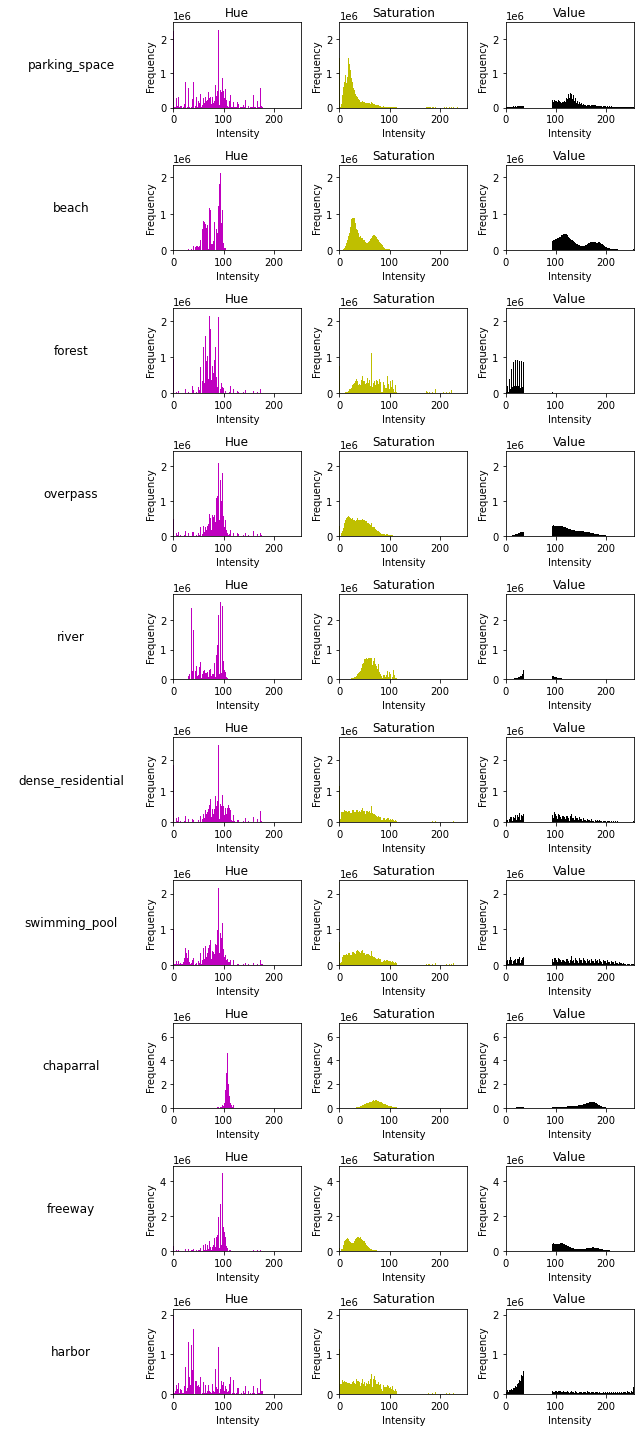

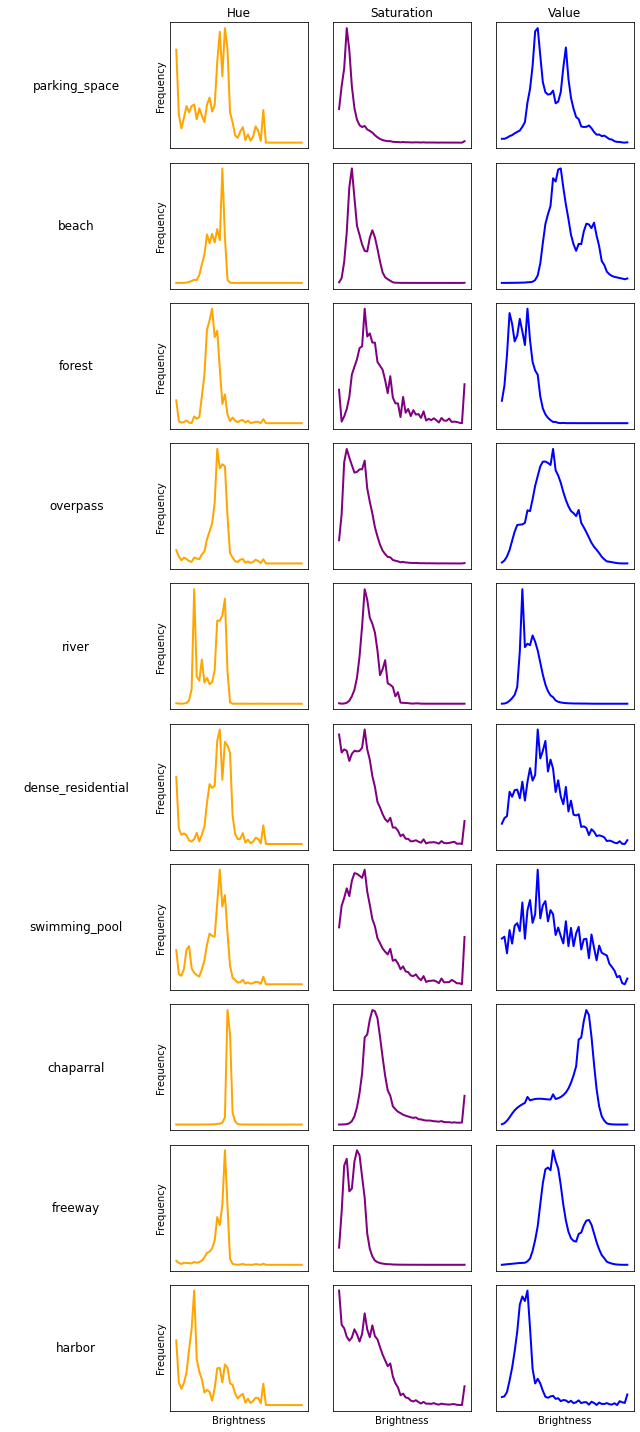

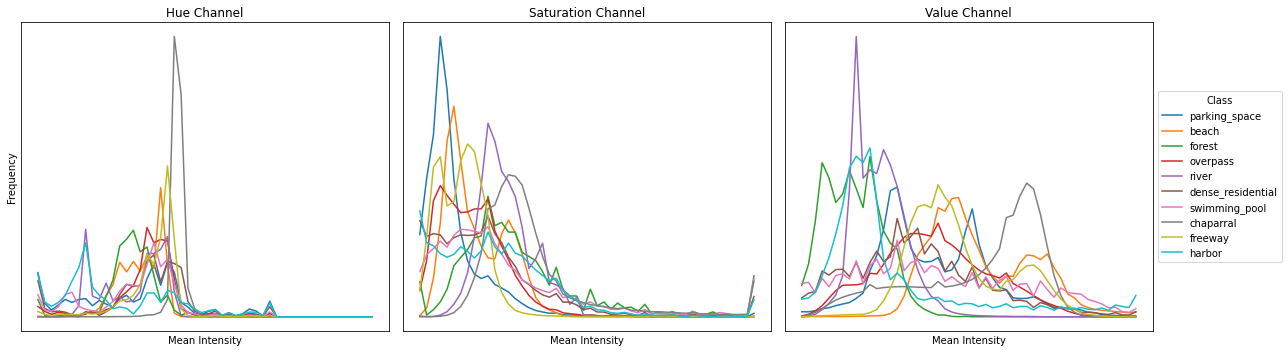

In [6]:
# generate histograms for HSV channels
generate_hist_channel_grid(train_files, directory, channels='hsv')

# generate distributions for mean intensity of HSV channels
generate_dist_channel_grid(train_files, directory, bins=50, channels='hsv')

# generate distributions for mean intensity of HSV channels for each class
class_histograms_hsv, legend_color_mapping_hsv = generate_channel_dist_grid(train_files, directory, bins=50, channels='hsv')

# Save data

In [7]:
# save histogram data to pickle file
with open('../data/processed/eda_class_hsv_histograms.pkl', 'wb') as f:
    pickle.dump(class_histograms_hsv, f)

In [8]:
# test loading histogram data from pickle file
with open('../data/processed/eda_class_hsv_histograms.pkl', 'rb') as f:
    class_rgb_histograms = pickle.load(f)

In [9]:
#class_rgb_histograms